In [21]:
import matplotlib.pyplot as plt
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from matplotlib.patches import Circle
from astropy import units as u
from matplotlib.colors import LogNorm, SymLogNorm
import matplotlib.animation
from astrosceni.image import Image

In [22]:
def getImage(path):
  filename = get_pkg_data_filename(path)
  hdu = fits.open(filename)
  
  image_data = hdu[0].data
  image_header = hdu[0].header

  return image_data, image_header

In [23]:
def plotHist(image_data, nbins=200):
  # flatten means: we put our 2d array in a 1d array
  histogram = plt.hist(image_data.flatten(), nbins)

  plt.xlabel('Pixel Content')
  plt.ylabel('Number of Pixels')
  plt.yscale('log')
  plt.show()

In [24]:
def plotImage(image_header, image_data):
  fig = plt.figure()

  wcs = WCS(image_header)
  ax = WCSAxes(fig, [0, 0, 1, 1], wcs=wcs)
  fig.add_axes(ax)

  # Now with an other colormap and in logscale
  img = ax.imshow(image_data, cmap='afmhot', norm=LogNorm())

  ax.set_xlabel('RA')
  ax.set_ylabel('Dec')

  ax.grid(color='white', ls='solid')

  # Set the limits of the colorbar and a label
  cb = fig.colorbar(img)
  # img.set_clim(1.1*np.min(image_data), np.max(image_data))
  cb.set_label('Counts')

  plt.show()

In [25]:
def subtractImages(NB_image_data, BB_image_data, scale_factor):
  subtracted_arr = BB_image_data * scale_factor
  return np.subtract(NB_image_data, subtracted_arr)

In [26]:
Ha_data, Ha_header = getImage('data/rim_Ha_wcs.fits')
R_data, R_header = getImage('data/rim_R_wcs.fits')
SII_data, SII_header = getImage('data/rim_[SII]_wcs.fits')

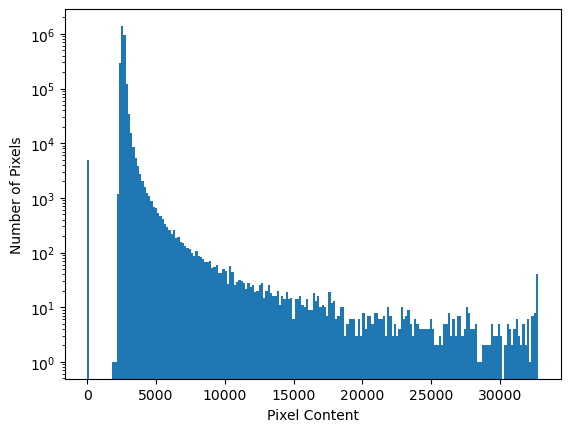

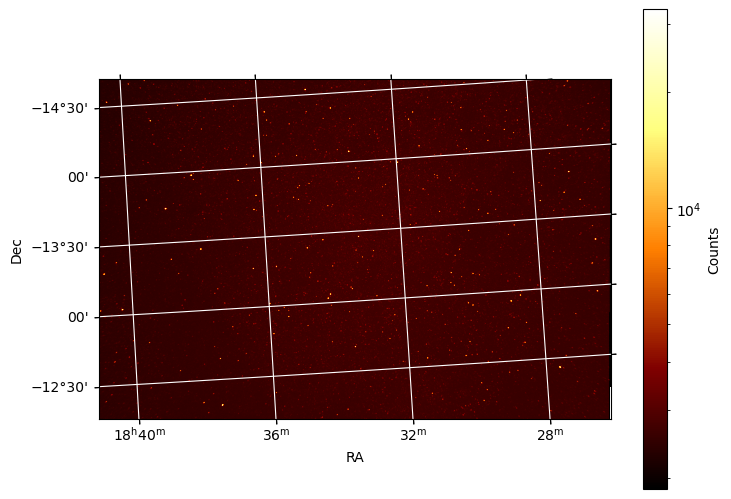

In [88]:
plotHist(R_data)
plotImage(R_header, R_data)

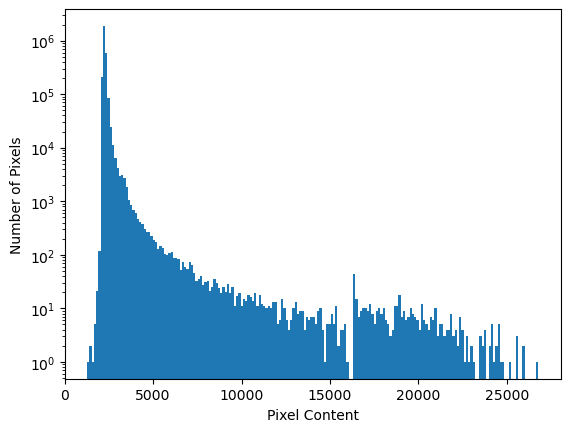

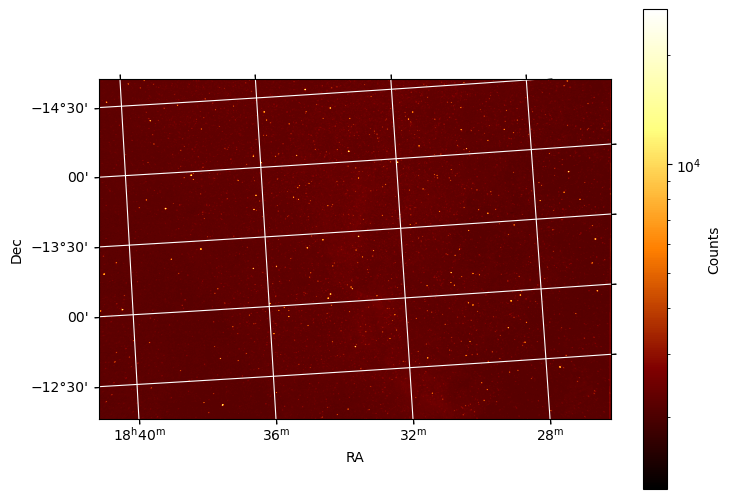

In [89]:
difference_image_data = subtractImages(Ha_data, R_data, 0.5)
plotHist(difference_image_data)
plotImage(R_header, difference_image_data)

In [ ]:
plt.close('all')
plt.rcParams["animation.html"] = "jshtml"
plt.ioff()
fig, ax = plt.subplots()

def animate(t):
    plt.cla()
    scale_factor = 0.5 + t*0.05
    # Now with an other colormap and in logscale
    img = ax.imshow(
        Ha_data - scale_factor*R_data, cmap='RdBu', 
        # vmin=np.min(Ha_data - R_data), vmax=np.max(Ha_data), 
        # vmin=0, vmax=1e4, 
        norm=LogNorm(
            vmin=0.001, vmax=5e3
            )
        # norm=SymLogNorm(
        #     # vmin=-1e4, vmax=1e4, 
        #     linthresh=0.03)
    )
    plt.text(0, -10, f"mu = {scale_factor}")
    if t == 1: fig.colorbar(img)

matplotlib.animation.FuncAnimation(fig, animate, frames=25)

In [30]:
def calculateSkew(image_data):
  data = np.array(image_data.flatten())
  N = len(data)
  mean = np.mean(data)   # Mean of the data
  std_dev = np.std(data, ddof=1)
  
  # Compute skewness
  return np.sum(((data - mean) / std_dev) ** 3) / (N - 1)

#Calculates skewness using function from paper
def calculateSkewLeo(data):
    skewness = 0 #Temporary
    pixelCount = np.size(data)
    mean = data.mean()
    std = data.std()
    for row in range(0, len(data)):
        for col in range(0, len(data[0])):
            skewness += ((data[row, col] - mean)/std)**3
    skewness = skewness/(pixelCount-1)
    return skewness

In [54]:
plt.ioff()
fig, ax = plt.subplots()

nbins=301

img1 = Image()
img1.load("data/rim_R_wcs.fits")
img2 = Image()
img2.load("data/rim_Ha_wcs.fits")

print(img1.getImageData().shape)
# print(img2.getImageData().shape)

# img2.cropPixels(x_end=-20, y_start=20)
img2.cropPixels(x_end=2060, y_start=20)
img1.cropPixels(x_end=2060, y_start=20, original=True)
# 2038 -> -20
# 2048 -> -10
# 1 -> 1 (expected)

print(img1.getImageData().shape)
# print(img2.getImageData().shape)

# (1392, 2080)
# (1392, 2080)

# (1371, 2038)
# (1371, 2059)

def animate(t):
  plt.cla()
  # Now with an other colormap and in logscale
  plt.hist((Ha_data - t*0.1*R_data).flatten(), nbins, range=(-30000, 30000))
  plt.text(0, 1, f"mu = {round(t*0.1, 2)}", ha='left', va='top', transform=ax.transAxes)
  plt.text(0.2, 1, f"skew = {round(calculateSkew(img2.getImageData() - t*0.1*img1.getImageData()), 2)}", ha='left', va='top', transform=ax.transAxes)
  plt.yscale('log')

matplotlib.animation.FuncAnimation(fig, animate, frames=20)

(1392, 2080)
(1371, 2060)


In [55]:
Ha_data = img2.getImageData()
R_data = img1.getImageData()


def getSkews(NB_image_data, BB_image_data, scale_factor_linspace):
  skews = []
  for mu in scale_factor_linspace:
    skews.append(calculateSkew(NB_image_data - mu*BB_image_data))
  return skews

In [86]:
scale_factors = np.linspace(0, 0.8, 500)
Ha_R_skews = getSkews(Ha_data, R_data, scale_factors)

[34.21759548256728, 34.22081331775875, 34.22405664636282, 34.22729714236549, 34.23055180137516, 34.23378379957362, 34.2370582867931, 34.24028461978877, 34.24356760481245, 34.24683642682913, 34.250110914048605, 34.253345744848474, 34.25663156247356, 34.25995703651825, 34.263248519346135, 34.266545667376825, 34.269862643617316, 34.27311730262699, 34.2764880982941, 34.279807907136, 34.283110720369486, 34.28646168782679, 34.289806990081296, 34.29310413811198, 34.2965032597931, 34.29985422725041, 34.303225022917516, 34.30658448817902, 34.30993545563633, 34.313326079513246, 34.31667987957195, 34.320095996861475, 34.323489453339796, 34.32690557062932, 34.33031035751325, 34.33370381399156, 34.337125596483894, 34.34058986799723, 34.34395499846154, 34.34740793956928, 34.35086937848122, 34.35431098918336, 34.357727106472886, 34.36118288018202, 34.36468397551358, 34.36812558621571, 34.371595522931855, 34.375065459648, 34.378572220182356, 34.3820478221013, 34.385546084831454, 34.389055677967214, 34

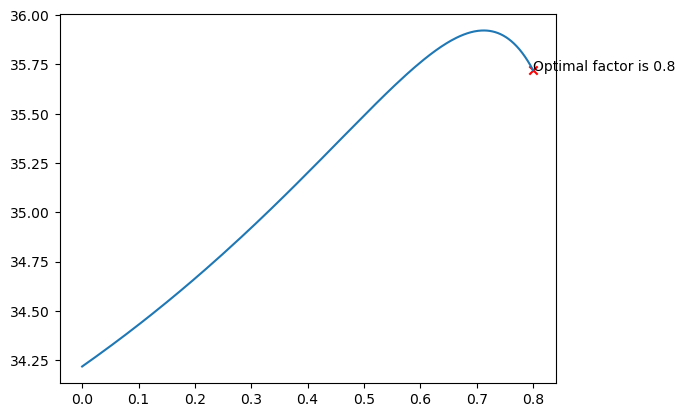

In [87]:
def find_nearest_zero(array, l=0, b=None):
    if b is None:
        b = len(array)
    
    # Base case: If there is one element left, return its index
    if b - l == 1:
        return l
    
    # Find the midpoint of the current range
    mid = (l + b) // 2

    # Check the midpoint value
    if array[mid] == 0:
        return mid  # Found exact zero
    elif array[mid] > 0:
        # Look in the lower half (towards smaller absolute values)
        return find_nearest_zero(array, l=mid, b=b)
    else:
        # Look in the upper half (towards smaller absolute values)
        return find_nearest_zero(array, l=l, b=mid)

plt.close('all')
plt.plot(scale_factors, Ha_R_skews)
pt = [scale_factors[find_nearest_zero(Ha_R_skews)], Ha_R_skews[find_nearest_zero(Ha_R_skews)]]
plt.scatter(pt[0], pt[1], c='r', marker='x')
plt.text(pt[0], pt[1], f'Optimal factor is {round(pt[0], 3)}')
print(Ha_R_skews)
plt.show()

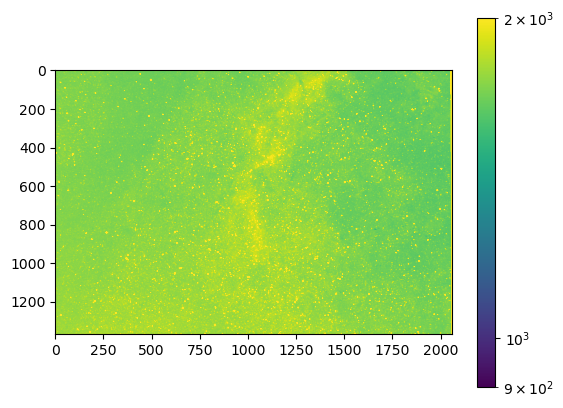

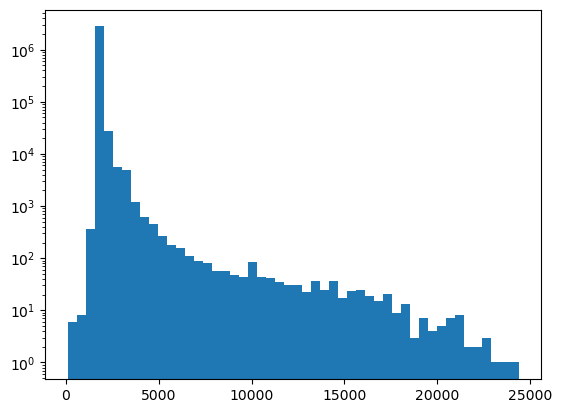

In [ ]:
Ha_data = img2.getImageData()
R_data = img1.getImageData()
plt.close('all')

scale_factor = 0.9

plt.imshow(
    Ha_data - scale_factor*R_data,
    # vmin=np.min(Ha_data - R_data), vmax=np.max(Ha_data), 
    # vmin=0, vmax=1e4, 
    norm=LogNorm(
        vmin=2000, vmax=1e3
        )
    # norm=SymLogNorm(
    #     # vmin=-1e4, vmax=1e4, 
    #     linthresh=0.03)
)
# plt.text(0, -10, f"mu = {scale_factor}")
plt.colorbar()
plt.show()
plt.hist((Ha_data - scale_factor*R_data).flatten(), bins=50)
plt.yscale('log')
plt.show()
